## Nearest Neighbors: a 'toy' problem

In [104]:
# GNN
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import os
import shutil
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.optim as optim
from random import shuffle
from torch_scatter import scatter_add
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau

# visualization
import networkx as nx
from torch_geometric.utils import to_networkx
import re
import cv2
from IPython.display import Video

Rather than turn immediately to a task which might pose some challenges to the GNN, it is common in machine learning research to start with a problem that is very simple and predictable. This way, we can ensure we have a data processing methodology, a funcitonal model, and a good file structure and workflow.

LAMMPS provides us with what we term 'dump files' which write a range of data fields for each particle at a given molecular dynamics (MD) time step. LAMMPS also provides a separate file for each simulation run which enumerates the wall particles for ease of identification. We then pre-process these files to create a 'snapshot' file. This snapshot packages the relevant feature and target information for the Pytorch model to pick up and use as a graph, and the training and validation of the model is performed with a Python script.

We chose to predict the number of particles within a certain distance of each particle for our 'toy' problem.

### Pre-processing of LAMMPS data files

Here is what a typical LAMMPS file looks like:

In [110]:
md_data = np.genfromtxt('../MD_Data/confdumpallelasticMD0.data', delimiter='\t', dtype=str, encoding='utf-8')

for line in md_data[:12]:
    print(line)

ITEM: TIMESTEP
0
ITEM: NUMBER OF ATOMS
4556
ITEM: BOX BOUNDS pp ff pp
0.0000000000000000e+00 1.5011186343322501e+02
0.0000000000000000e+00 1.6691186343322499e+02
-1.0000000000000000e-02 1.0000000000000000e-02
ITEM: ATOMS id type x y vx vy fx fy xu yu c_shearStr[4] c_shearStr[1] c_shearStr[2] v_coordA v_coordB v_coordA_wall v_coordB_wall
1 1     3.8648859854e+01     3.2112242274e+00    -7.5055931717e-05     0.0000000000e+00     3.4586453725e-11     5.7813394608e-11     3.8648859854e+01     3.2112242274e+00     1.3519282798e-05    -1.2264112750e-05    -2.5524784962e-05 0 0 0 0
2 1     3.7909600531e+01     1.3528864139e+00    -7.5055931717e-05     0.0000000000e+00     2.6097361752e-05    -4.9940246666e-05     3.7909600531e+01     1.3528864139e+00    -5.7883085646e-06    -5.3316321409e-04    -1.3450328920e-04 0 0 0 0
3 1     1.6100689340e+01     4.3742392364e+00    -7.5055931717e-05     0.0000000000e+00     2.1923683691e-10     1.3667568596e-11     1.6100689340e+01     4.3742392364e+00    

In [111]:
from pre_processors.Pre_processing_neighbors import process_lammps_dump
from customDataset import CustDataset

In [112]:
process_lammps_dump("../MD_Data/confdumpallelasticMD0.data", "../MD_Data/wallpartidtype", cutoff_distance=5.0, train_fraction=0.9)

Output written to Snapshot_1.graphdata


The $\texttt{customDataset.py}$ file reads data from the Snapshot_1 file in order to construct a graph representation of the data which is usable by Pytorch. The most important function of the script is the $\texttt{getitem(self, index)}$ method which governs the initialization of nodes and edges, and I will give some code/pseudocode snippets of this method below rather than simply calling the $\texttt{CustDataset}$ class which we have imported above.

In [114]:
img_path = './Snapshot_1.graphdata'
x = np.loadtxt(img_path)
temp = np.array(x)
box = temp[0,:2] # simulation box length in x and y dimensions
positions = temp[1:,1:3] # atom x,y-coordinates
wall_flag = temp[1:,3] # is particle a wall particle?
target = temp[1:,4] # what is the target property for this particle?

# define the edge threshold h, which determines whether or not particles/nodes will be connected by an edge in the graph
h = 5.0 # edge threshold

In [115]:
# identifying nodes that are part of training and validation data
train_mask = (temp[1:,5]==1)
val_mask = (temp[1:,5]==0)
print(train_mask.sum(),val_mask.sum())

# Atom type encoding (one-hot) -- convert to something Pytorch can handle
atom_type = torch.tensor(temp[1:,0] - 1) # atom type (assuming 0-based indexing)
atom_type = torch.nn.functional.one_hot(atom_type.to(torch.int64), num_classes=-1) #0->[1,0]; 1->[0,1]
atom_type = atom_type.clone().detach().to(torch.float)

# is particle a wall particle?
# Wall flag encoding (binary feature)
wall_flag = torch.tensor(wall_flag).unsqueeze(1).float()  # (n_nodes, 1)

# Concatenate atom type and wall flag to create final node features
node_features = torch.cat([atom_type, wall_flag], dim=1)  # Concatenate along the feature dimension

# Calculate pairwise relative distances between particles: shape [n, n, 2].
cross_positions = positions[np.newaxis, :, :] - positions[:, np.newaxis, :]
# Enforce periodic boundary conditions in the x-direction only
box_x = box[0]
cross_positions[:, :, 0] += (cross_positions[:, :, 0] < -box_x / 2.) * box_x
cross_positions[:, :, 0] -= (cross_positions[:, :, 0] > box_x / 2.) * box_x


distances = np.linalg.norm(cross_positions, axis=-1)
indices = np.where(distances < h)

mask = indices[0] != indices[1]
senders = list(indices[0][mask]); receivers = list(indices[1][mask])
edge_index = torch.tensor([senders,receivers],dtype=torch.long)

edges = cross_positions[senders[0],receivers[0]]

for i,j in zip(senders[1:],receivers[1:]):
    edges = np.vstack([edges, cross_positions[i,j]])
 
edge_attr = torch.tensor(edges, dtype=torch.float)

globals = torch.zeros((1,1),dtype=torch.float)
    
positions = torch.tensor(positions, dtype=torch.float)

4100 456


In [116]:
# now we have our target:
y = torch.tensor(target, dtype=torch.float)
# and our graph representation of the system:
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, globals=globals, train_mask=train_mask, val_mask=val_mask)

In [117]:
# To visualize the graph structure
mask = temp[1:,0]
mask = torch.tensor(mask, dtype=torch.int)
mask = mask.bool()
color = mask
data = Data(color=color,x=node_features, edge_index=edge_index, edge_attr=edge_attr, globals=globals, train_mask=train_mask, val_mask=val_mask)

In [118]:
def visualize_graph(data, color='skyblue'):
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=False,
        node_color=color,
        node_size=10,
        alpha=0.4,
        edge_color='gray',
        width=0.2
    )
    plt.show()

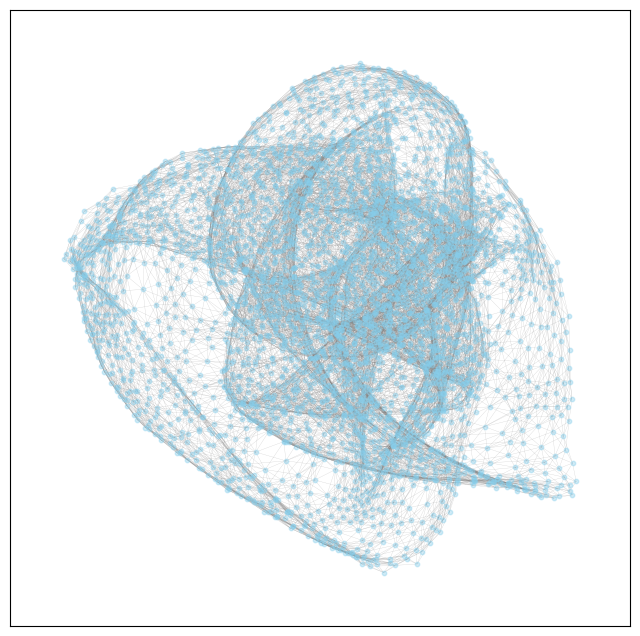

In [119]:
visualize_graph(data, 'skyblue')

This looks cool, but it doesn't tell us (or at least me) much about the physics of the system... and that's the point!

In other words, we've moved from our MD system snapshot to a graph which will be fed to the GNN.

### GNN implementation

#### Pytorch architecture

Drawing from the $\texttt{gnn\_old.py}$ script, which constitutes the skeleton of the GNN which we have since built upon and refined, I will give you an idea of the mechanism of a PyTorch GNN implementation. The $\texttt{gnn\_with\_train\_and\_savedmodel.py}$ version is also provided, which expands upon the original model by writing actual and predicted values for training and validation and by allowing the training loop to be stopped and picked up again from a given checkpoint.

For all versions of the GNN code, see this [Google Drive folder](https://drive.google.com/drive/folders/1qoVhFsLf4IrfTRDPD7tuH26-kurvxgfZ?usp=sharing). The most advanced, discussed below, is $\texttt{gnn\_ema\_earlystop\_norm.py}$.

The model follows the structure of an interaction network, which is a type of message-passing neural network designed for learning on graphs. It uses separate models for updating edge features, node features, and (optionally) global graph-level features.

The $\texttt{EdgeModel}$ class defines how the attributes of graph edges are updated. For each edge, it considers:

- The features of the source and destination nodes it connects
- Its own edge attributes

These are concatenated and passed through a multi-layer perceptron (MLP) with ReLU activations:

In [143]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super(EdgeModel, self).__init__()
        self.edge_mlp = nn.Sequential(nn.Linear(2*(2*emb_dim+emb_dim), emb_dim), # 2*num_node_features + num_edge_features
                            nn.ReLU(),
                            nn.Linear(emb_dim, emb_dim),
                            nn.ReLU())

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr], 1) # out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        out = self.edge_mlp(out)
        return out

The $\texttt{NodeModel}$ class defines how node attributes are updated. The process is as follows:

1) Each node receives messages from its neighbors via incoming edges, where messages are computed using the sender node's features and edge attributes.
2) These messages are summed up and concatenated with the node's own features.
3) The resulting vector is passed through another MLP to produce updated node features.

In [145]:
class NodeModel(torch.nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.node_mlp_1 = nn.Sequential(nn.Linear(2*emb_dim+emb_dim, emb_dim),
                              nn.ReLU(), 
                              nn.Linear(emb_dim, emb_dim),
                              nn.ReLU())
        self.node_mlp_2 = nn.Sequential(nn.Linear(2*emb_dim+emb_dim, emb_dim),
                              nn.ReLU(), 
                              nn.Linear(emb_dim, emb_dim),
                              nn.ReLU())

    def forward(self, x, edge_index, edge_attr, u, batch):
        senders, receivers = edge_index
        out = torch.cat([x[senders], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_add(out, receivers, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1) # out = torch.cat([x, out, u[batch]], dim=1)
        out = self.node_mlp_2(out)  
        return out

The $\texttt{GlobalModel}$ is intended to update global (graph-level) attributes. In this implementation, it is set to an identity mapping, meaning no global features are used or updated.

In [147]:
class GlobalModel(torch.nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        """self.global_mlp = nn.Sequential(nn.Linear(emb_dim+1, emb_dim), #num_node_features + num_edge_features + 1
                              nn.BatchNorm1d(emb_dim),
                              nn.ReLU(), 
                              nn.Linear(emb_dim, emb_dim))"""
        self.global_mlp = nn.Identity()

    def forward(self, x, edge_index, edge_attr, u, batch):
        # out = torch.cat([u, scatter_add(x, batch, dim=0)], dim=1)
        # return self.global_mlp(out)
        return self.global_mlp(u)

The full $\texttt{InteractionNetwork}$ class orchestrates the entire GNN as follows:

1) Encoding: Node and edge features are first projected into a higher-dimensional embedding space using separate MLP encoders.
2) Message Passing: The GNN runs for a user-defined number of layers of message passing. In each layer: (i) Edges are updated based on node features and previous edge features. (ii) Nodes are then updated based on messages from edges. (iii) Previous embeddings are concatenated to stabilize learning.
5) Output: Final node features are passed through fully connected layers to produce per-node predictions.

In [149]:
class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()

        MLP_dim = 256 #num. of neurons in fully-connected layers at the end
        
        self.fc1 = nn.Linear(node_dim, emb_dim)
        self.fc2 = nn.Linear(emb_dim, emb_dim)
        
        self.fc3 = nn.Linear(emb_dim, MLP_dim)
        self.fc4 = nn.Linear(MLP_dim, MLP_dim)
        self.fc5 = nn.Linear(MLP_dim, output_dim)

        self.edgefc1 = nn.Linear(edge_dim, emb_dim)
        self.edgefc2 = nn.Linear(emb_dim, emb_dim)

        self.act = nn.ReLU()

        self.interactionnetwork = MetaLayer(edge_model=EdgeModel(), node_model=NodeModel(), global_model=None)
        # self.bn = BatchNorm1d(inputs)
        
    def forward(self, data):
        
        MP_layers = 7 # num. of message-passing layers
        x, edge_index, edge_attr, globals, batch = data.x, data.edge_index, data.edge_attr, data.globals, data.batch #x = self.bn(x)

        #encoder phase
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        
        edge_attr = self.edgefc1(edge_attr)
        edge_attr = self.act(edge_attr)
        edge_attr = self.edgefc2(edge_attr)
        edge_attr = self.act(edge_attr)
        
        save_x = x
        save_edge_attr = edge_attr
        
        #Message-passing layers
        for _ in range(MP_layers):
          #concatenate current values with 'save'd values.. concept of residual network
          x = torch.cat([x, save_x], dim=1)
          edge_attr = torch.cat([edge_attr, save_edge_attr], dim=1)
          
          x, edge_attr, globals = self.interactionnetwork(x=x, edge_index=edge_index, edge_attr=edge_attr, u=None, batch=batch)

        x = self.fc3(x)
        x = self.act(x)
        x = self.fc4(x)
        x = self.act(x)
        x = self.fc5(x)
        
        return x

In the context of our application of the GNN architecture to LAMMPS dump files, the number of message passing layers is a reflection of how far information can propagate through the system. This characteristic of the GNN combined with the edge threshold parameter in our data pre-processor determine the model's capacity to predict targets which are correlated with the graph structure. In other words, to predict distance information from each particle to a landmark (say, a pin, which Amy Graves has demonstrated in Siddhant Ranka's report), the model is very capable of predicting distances up until a distance of $N_{MP\_layers} * edge\_threshold$, after which point it can still learn the target but with less ease.

In [151]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


The following parameters govern the processing of the graph data by the GNN:

In [153]:
# Parameters and Hyperparameters
node_dim = 3 # node feature dimension: x and y coordinates (2) and whether particle is wall particle (3)
edge_dim = 2 # 2D relative position vector between nodes
output_dim = 1 # single-dim target (number of neighbors)
edge_threshold = 5.0 # two nodes form an edge if separation shorter than threshold
emb_dim = 64 # embedding dimension of the nodes and edges

while, as described above, the learning rate determines the amount by which the weights are displaced by the update vector at each pass through the training data. A learning rate that is small might allow for a meticulous navigation of the loss function towards a favorable minimum, at the expense of a slow convergence or of updates to the weights that are so small they cause floating point error. On the other hand, a learning rate that is large might enable the model to jump from a local to a global minimum and to gather a holistic representation of the loss landscape, but this could also produce models which diverge or which oscillate capriciously rather than actually reaching the bottom of a valley in the loss.

Each pass through the training data constitutes an 'epoch.' So, in theory, running a convergent model for increasing numbers of epochs would result in better and better performance.

In [155]:
learning_rate = 0.0001
num_epochs = 1

In [166]:
dataset = CustDataset(h=edge_threshold, root_dir='./')
data_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
cache_directory = 'cached_data'

if os.path.exists(cache_directory): shutil.rmtree(cache_directory)
os.makedirs(cache_directory, exist_ok=True)

Move the data into the cache directory and onto the device, and initialize the model. To save a little time, I've included a saved model state in the $\texttt{savedmodel\_neighbors.pkl}$ file, which has been trained for 520 epochs to achieve an RMSE of below $10^{-5}$ (in units of neighbors per particle). So, we'll load this state and all of its learned parameters rather than starting from an untrained model.

In [168]:
for i, (data, targets) in enumerate(data_loader):
    torch.save((data,targets), os.path.join(cache_directory, f'data_{i}.pt'))

if os.path.exists("../saved_model_states/savedmodel_neighbors.pkl"):
    # resume training from previous model state
    print("Loading existing model...")
    model = torch.load("../saved_model_states/savedmodel_neighbors.pkl", weights_only=False)
else: # otherwise start new model
    print("Initializing new model...")
    model = InteractionNetwork()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")

model.to(device)

training particles: 4100
validation particles: 456
Loading existing model...


InteractionNetwork(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=1, bias=True)
  (edgefc1): Linear(in_features=2, out_features=64, bias=True)
  (edgefc2): Linear(in_features=64, out_features=64, bias=True)
  (act): ReLU()
  (interactionnetwork): MetaLayer(
    edge_model=EdgeModel(
    (edge_mlp): Sequential(
      (0): Linear(in_features=384, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
    )
  ),
    node_model=NodeModel(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_

#### Loss function (RMSE)

The loss function we use is root mean squared error (RMSE), which is standard for regression tasks such as our own.

Below we plot the RMSE of our model across its first 500 epochs of training on a log-log scale:

![Log(RMSE) from saved model state across 500 epochs](../images/Neighbors_savedmodel_RMSE.png)

#### Training and evaluation

The loss function and optimizer are set here. We use $\texttt{Adam}$ (adaptive moment estimation), which updates weights by tracking the mean and variance of the loss function's gradient as weighted averages of the current and previous states.

However, I am also interested in testing simpler optimizers: stochastic gradient descent (SGD) simply uses the current loss gradient; and AdaGrad (adaptive gradient) normalizes the learning rate for each parameter by a factor proportional to the sum of the squares of previous loss gradients and thus can differentiate which parameters need to be updated by larger amounts.

In [174]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In the GNN versions we use, a $\texttt{check\_accuracy()}$ function is called at each epoch (i.e., iteration of the training loop) which computes RMSE and writes the actual/target and predicted/model-output values to a file). We also write the learning rate at each epoch and save the model state. For our purposes, instead of writing a file, we'll simply make a couple print statements:

In [176]:
def check_accuracy(cache_files, model, phase):
    model.eval()
    quantify = 0.0
    count = 0
    if phase == 'train': print_phase = 'training'
    if phase == 'val': print_phase = 'validation'

    with torch.no_grad():
        for cache_file in cache_files:
            data, targets = torch.load(os.path.join(cache_directory, cache_file), weights_only=False)
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            scores = scores.reshape(-1)
            targets = targets.reshape(-1)

            mask = np.array(data.train_mask if phase == "train" else data.val_mask).reshape(-1)
            masked_indices = np.where(mask)[0]

            quantify += criterion(scores[mask], targets[mask])
            count += 1

            # Randomly select 3 indices from the valid (masked) entries
            if len(masked_indices) >= 3:
                selected_indices = random.sample(list(masked_indices), 3)
            else:
                selected_indices = masked_indices

            print("Sampled predictions for number of neighbors of 3 random %s particles:" % print_phase)
            for idx in selected_indices:
                print(f"Actual: {targets[idx].item():.4f}, Predicted: {scores[idx].item():.4f}")

    print()
    print("RMSE is %s\n" % (quantify.item() / count))

    # we'll just return the actual and predicted values for use below
    actual_vals = targets[mask]
    predicted_vals = scores[mask]

    return actual_vals, predicted_vals

We'll now run one epoch of training of this model for the neighbors task. Normally, the code below is wrapped in a for loop and iterates for as many epochs as we'd like, but we'll avoid this for now. We also won't save the model's weights and biases after our single epoch to reduce clutter in the file structure of this computational essay :)

In [178]:
epoch = 521
for phase in ['train', 'val']:
    if phase == 'train':
      model.train()  # Set model to training mode
    else:
      model.eval()   # Set model to evaluate mode

    running_loss = 0.
    count = 0

    cache_files = [f for f in os.listdir(cache_directory) if f.endswith('.pt')]
    if phase == 'train': shuffle(cache_files)
    for cache_file in cache_files:
      data,targets = torch.load(os.path.join(cache_directory, cache_file),weights_only=False)
      data = data.to(device=device)
      targets = targets.to(device=device)

      if phase == 'train': mask = data.train_mask
      else: mask = data.val_mask

      # Determine the batch size for this graph
      if phase == 'train': batch_size = 32
      else: batch_size = np.sum(mask)
      true_indices = np.where(mask)[1]
      num_batches = (len(true_indices) + batch_size - 1) // batch_size

      # Iterate through nodes in batches
      for i in range(num_batches):
        optimizer.zero_grad()
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(true_indices))

        batch_indices = true_indices[start_idx:end_idx]
        node_batch = np.zeros(len(mask[0]), dtype=bool)
        node_batch[batch_indices] = True

        with torch.set_grad_enabled(phase == 'train'):
          optimizer.zero_grad()
          scores = model(data)
          scores = scores.reshape(-1); targets = targets.reshape(-1); node_batch = np.array(node_batch).reshape(-1)
          loss = criterion(scores[mask], targets[mask])
          running_loss +=loss.item()
          count += 1

          # backward + optimize (update weights) only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

    if phase == 'train': print_phase = 'Training'
    if phase == 'val': print_phase = 'Validation'

    print('{} Loss - epoch {}: {:.10f}'.format(print_phase, epoch, running_loss/count))

    if phase == 'train':
        actual_train, predicted_train = check_accuracy(cache_files, model, phase)
    if phase == 'val':
        actual_val, predicted_val = check_accuracy(cache_files, model, phase)
        
epoch += 1

Training Loss - epoch 521: 0.0149716286
Sampled predictions for number of neighbors of 3 random training particles:
Actual: 14.0000, Predicted: 13.9910
Actual: 12.0000, Predicted: 12.0037
Actual: 18.0000, Predicted: 17.9971

RMSE is 8.68954521138221e-06

Validation Loss - epoch 521: 0.0000085682
Sampled predictions for number of neighbors of 3 random validation particles:
Actual: 15.0000, Predicted: 14.9965
Actual: 15.0000, Predicted: 15.0013
Actual: 12.0000, Predicted: 12.0026

RMSE is 8.568178600398824e-06



You can keep re-running the above cell if you'd like, and you might see the loss continue to decrease as we iterate over the training data and train the model for more and more epochs.

Otherwise, that's it for our skeleton GNN!

Our sampled predictions for 3 random particles should show you that the model is quite successful in predicting the number of neighbors per particle within a certain distance, and we'll discuss another method of visualizing this below: the parity plot.

### Performance: the parity plot

The parity plot graphs the actual (target) values as a function of the model's predicted values.

The line $\texttt{y=x}$ indicates perfect model performance where predictions match the target. Vertical lines on the graph indicate 'false negatives' whereas horizontal lines indicate 'false positives.'

For the neighbors task, the actual values are discrete integer values.

Here is a parity plot of our current model's predictions, using the actual and predicted values we've just generated:

In [186]:
def parity_plot(y_train_actual, y_train_pred, y_val_actual, y_val_pred, title):
    plt.figure(figsize=(12, 6))

    # Training Parity Plot
    plt.subplot(1, 2, 1)
    plt.plot([y_train_actual.min(), y_train_actual.max()],
         [y_train_actual.min(), y_train_actual.max()],
         'k--', lw=1, label='Ideal', alpha=0.5)
    plt.scatter(y_train_actual.cpu(), y_train_pred.cpu(), 
                facecolors='none', edgecolors='blue', alpha=0.5, label='Training')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Training Parity Plot %s' % title)
    plt.legend()

    # Validation Parity Plot
    plt.subplot(1, 2, 2)
    plt.plot([y_val_actual.min(), y_val_actual.max()],
         [y_val_actual.min(), y_val_actual.max()],
         'k--', lw=1, label='Ideal', alpha=0.5)
    plt.scatter(y_val_actual.cpu(), y_val_pred.cpu(), 
                facecolors='none', edgecolors='green', alpha=0.5, label='Validation')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Validation Parity Plot %s' % title)
    plt.legend()

    plt.tight_layout()
    plt.show()

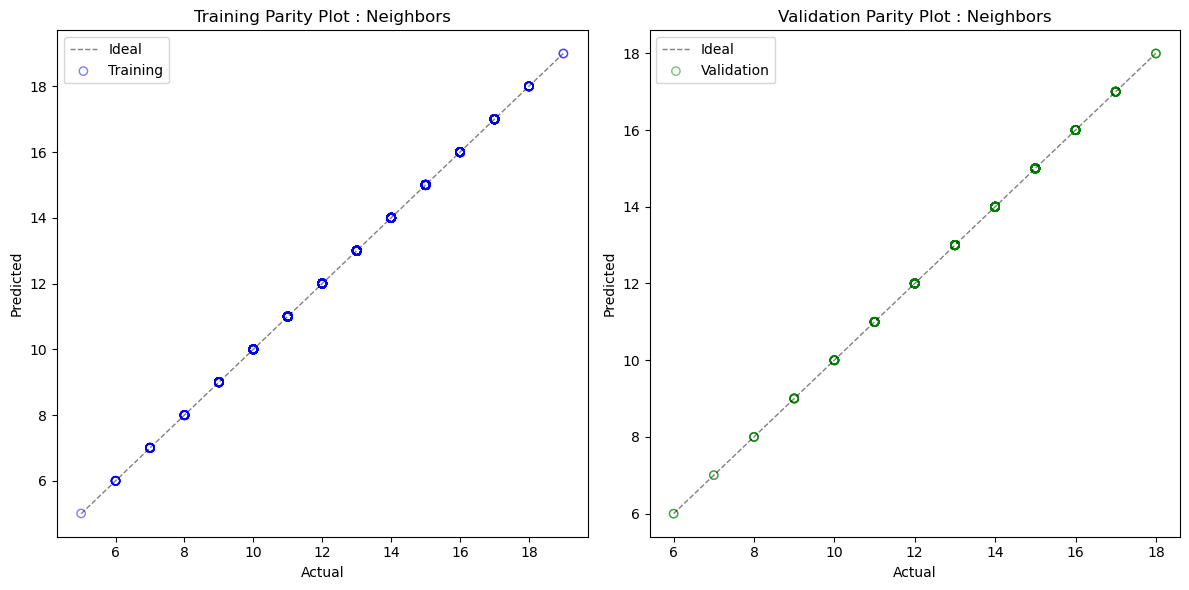

In [187]:
parity_plot(actual_train, predicted_train, actual_val, predicted_val, ": Neighbors")

### Hyperparameters, and how we choose them: tuning

In its current state, the main parameter which we'd like to optimize is the learning rate. The number of message passing layers, the embedded dimension, the edge threshold, and the multi-layer perceptron (MLP) dimension are also important to keep in mind.

Ideally, to find the best learning rate, we would train the model on a range of learning rates for hundreds of epochs and repeat this training process a few times to ensure the reproducibility and veracity of our conclusions. Since this was our 'toy' problem, however, we ran the model for 20 epochs for a variety of learning rates and found $10^{-4}$ to produce the lowest RMSE. 